<a href="https://colab.research.google.com/github/KOO-96/DNA_seminar/blob/main/DNA_ComputerVisionSeminar_Weeks6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
%cd /content/drive/MyDrive/CV_seminar_project

/content/drive/MyDrive/CV_seminar_project


In [27]:
%pwd

'/content/drive/MyDrive/CV_seminar_project'

In [28]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu' # device 배정
torch.manual_seed(42)
if device == 'cuda':
  torch.cuda.manual_seed_all(42)
device

'cuda'

# 1. 데이터 셋 준비하기

In [29]:
import torch.nn as nn

# 하이퍼 파라미터
batch_size = 8
lr = 0.0001
epochs = 100
optimizer_name = 'adam'
model_name = 'resnet50'
criterion = nn.CrossEntropyLoss().to(device) # cost function

In [30]:
from dataset import Custom_dataset as C
from torch.utils.data import Dataset, DataLoader
import cv2
import os 
import torch
import torchvision
from torchvision import transforms # 이미지 데이터 augmentation
import glob
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2 # albumentations 텐서화 함수

root_path = '/content/drive/MyDrive/CV_seminar_project'

train_transforms = A.Compose([
    A.Resize(224,224),
    A.Transpose(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=20, val_shift_limit=20, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
    A.ChannelShuffle(),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0), # 이미지넷 데이터셋 통계값으로 Normalize
    A.CoarseDropout(p=0.5),
    ToTensorV2()
])

test_transforms = A.Compose([
    A.Resize(224,224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0), # 텐서타입은 안해줌
    ToTensorV2() # Normalize를 먼저하고 tensor화를 진행해야한다.
])

### Pytorch 데이터 클래스 생성
train_class = C(root_path=root_path, mode='train', transforms=train_transforms)
valid_class = C(root_path=root_path, mode='valid', transforms=test_transforms)
test_class = C(root_path=root_path, mode='test', transforms=test_transforms)

### Pytorch BatchLoader 생성 (학습에 이용할 최종 dataloader)
from torch.utils.data import DataLoader as DataLoader

train_loader = DataLoader(train_class, batch_size=batch_size, shuffle = True, num_workers=0)
valid_loader = DataLoader(valid_class, batch_size=batch_size, shuffle = False, num_workers=0)
test_loader = DataLoader(test_class, batch_size=batch_size, shuffle = False, num_workers=0)

# 2. 모델 불러오기

In [31]:
from torchvision import models # 모델 라이브러리 함수

resnet_50 = models.resnet50(pretrained=True).to(device) # 선행학습 여부

# finetuning
import torch.nn as nn # 파이토치 뉴럴네트워크 layer 라이브러리
resnet_50.fc = nn.Linear(resnet_50.fc.in_features, 3).to(device)

In [32]:
from torchsummary import summary # 모델 아키텍쳐 확인하는 함수

summary(resnet_50, input_size = (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [33]:
optimizer = torch.optim.Adam(resnet_50.parameters(), lr = lr, weight_decay = 1e-8)

# 3. 모델 학습시키기

- 모델 저장하기: 딕셔너리 형식의 pth확장자로 저장이 된다.
- validation set의 성능이 여태까지 epoch의 성능에서 best일 때 모델의 가중치를 저장한다.

In [34]:
import numpy as np

train_acc_lst = []
train_loss_lst = []

test_acc_lst = []
test_loss_lst = []
epochs = 10

save_dir = '/content/drive/MyDrive/CV_seminar_project'
model_name = 'resnet_50'

for epoch in range(1, epochs):
  running_loss = 0.0
  test_running_loss = 0.0

  total = 0
  correct = 0
  
  train_acc = 0
  test_acc = 0

  resnet_50.train()
  for i, (train_img, train_label) in enumerate(train_loader):
    # gpu에 할당
    train_img = train_img.to(device)
    train_label = train_label.to(device)
    optimizer.zero_grad( set_to_none = True ) # 계산했던 가중치 초기화

    output = resnet_50(train_img) # 모델에 입력
    loss = criterion(output, train_label)
    loss.backward() # 미분
    optimizer.step() # 학습

    # loss & acc
    running_loss += loss.item()
    _, predictions = torch.max(output.data ,dim = 1 )
    
    total += train_label.size(0)
    correct += (predictions == train_label).sum().item()
    train_acc += 100 * (correct/total)

  running_loss = round(running_loss/(i+1), 3) # 소수점 반올림
  train_acc = round(train_acc/(i+1), 3)
  
  print(f'Trainset{epoch}/{epochs} Loss : {running_loss}, Accuracy : {train_acc}%')
  train_acc_lst.append(train_acc)
  train_loss_lst.append(running_loss)


  total = 0
  correct = 0
  resnet_50.eval()
  with torch.no_grad():
    for ii, (test_img, test_label) in enumerate(test_loader):
          # gpu에 할당
      test_img = test_img.to(device)
      test_label = test_label.to(device)

      output = resnet_50(test_img) # 모델에 입력
      loss = criterion(output, test_label)

      # loss & acc
      test_running_loss += loss.item()
      _, predictions = torch.max(output.data ,dim = 1 )
      
      total += test_label.size(0)
      correct += (predictions == test_label).sum().item()
      test_acc += 100 * (correct/total)

  test_running_loss = round(test_running_loss/(ii+1), 3) # 소수점 반올림
  test_acc = round(test_acc/(ii+1), 3)
  print(f'testset{epoch}/{epochs} Loss : {test_running_loss}, Accuracy : {test_acc}% \n')
  test_acc_lst.append(test_acc)
  test_loss_lst.append(test_running_loss)

Trainset1/10 Loss : 0.849, Accuracy : 56.014%
testset1/10 Loss : 0.719, Accuracy : 73.573% 

Trainset2/10 Loss : 0.675, Accuracy : 70.875%
testset2/10 Loss : 0.531, Accuracy : 77.817% 

Trainset3/10 Loss : 0.656, Accuracy : 73.116%
testset3/10 Loss : 0.452, Accuracy : 81.031% 

Trainset4/10 Loss : 0.574, Accuracy : 76.655%
testset4/10 Loss : 0.494, Accuracy : 74.591% 

Trainset5/10 Loss : 0.503, Accuracy : 79.192%
testset5/10 Loss : 0.443, Accuracy : 81.805% 

Trainset6/10 Loss : 0.494, Accuracy : 81.158%
testset6/10 Loss : 0.351, Accuracy : 84.694% 

Trainset7/10 Loss : 0.431, Accuracy : 83.596%
testset7/10 Loss : 0.327, Accuracy : 85.311% 

Trainset8/10 Loss : 0.507, Accuracy : 78.15%
testset8/10 Loss : 0.386, Accuracy : 85.042% 

Trainset9/10 Loss : 0.444, Accuracy : 82.111%
testset9/10 Loss : 0.3, Accuracy : 81.225% 



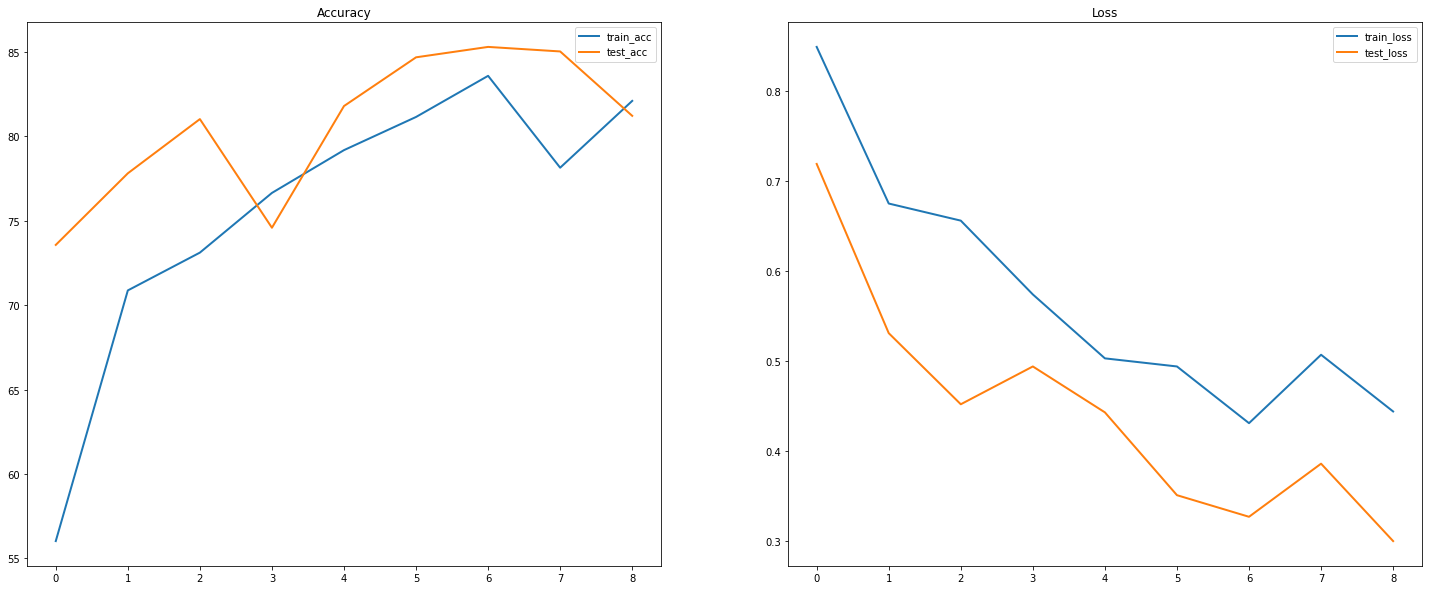

In [35]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np

fig, axes = plt.subplots(nrows=1, ncols = 2, figsize = (25, 10))

axes[0].plot(np.arange(len(train_acc_lst)), train_acc_lst, label = 'train_acc', linewidth=2)
axes[0].plot(np.arange(len(test_acc_lst)), test_acc_lst, label = 'test_acc', linewidth=2)
axes[0].set_title('Accuracy')
axes[0].legend(loc='best')

axes[1].plot(np.arange(len(train_loss_lst)), train_loss_lst, label = 'train_loss', linewidth=2)
axes[1].plot(np.arange(len(test_loss_lst)), test_loss_lst, label = 'test_loss', linewidth=2)
axes[1].set_title('Loss')
axes[1].legend(loc='best')

homeworks
>모델은 100epoch를 돌려서 만든 가중치를 이용한다.  
>testloader를 생성하여, 최종 성능을 평가한다.  
>tensorbord는 자율로 이용하시오.

In [36]:
import numpy as np

train_acc_lst = []
train_loss_lst = []

test_acc_lst = []
test_loss_lst = []
epochs = 100

save_dir = '/content/drive/MyDrive/CV_seminar_project'
model_name = 'resnet_50'

for epoch in range(1, epochs):
  running_loss = 0.0
  test_running_loss = 0.0

  total = 0
  correct = 0
  
  train_acc = 0
  test_acc = 0

  resnet_50.train()
  for i, (train_img, train_label) in enumerate(train_loader):
    # gpu에 할당
    train_img = train_img.to(device)
    train_label = train_label.to(device)
    optimizer.zero_grad( set_to_none = True ) # 계산했던 가중치 초기화

    output = resnet_50(train_img) # 모델에 입력
    loss = criterion(output, train_label)
    loss.backward() # 미분
    optimizer.step() # 학습

    # loss & acc
    running_loss += loss.item()
    _, predictions = torch.max(output.data ,dim = 1 )
    
    total += train_label.size(0)
    correct += (predictions == train_label).sum().item()
    train_acc += 100 * (correct/total)

  running_loss = round(running_loss/(i+1), 3) # 소수점 반올림
  train_acc = round(train_acc/(i+1), 3)
  
  print(f'Trainset{epoch}/{epochs} Loss : {running_loss}, Accuracy : {train_acc}%')
  train_acc_lst.append(train_acc)
  train_loss_lst.append(running_loss)


  total = 0
  correct = 0
  resnet_50.eval()
  with torch.no_grad():
    for ii, (test_img, test_label) in enumerate(test_loader):
          # gpu에 할당
      test_img = test_img.to(device)
      test_label = test_label.to(device)

      output = resnet_50(test_img) # 모델에 입력
      loss = criterion(output, test_label)

      # loss & acc
      test_running_loss += loss.item()
      _, predictions = torch.max(output.data ,dim = 1 )
      
      total += test_label.size(0)
      correct += (predictions == test_label).sum().item()
      test_acc += 100 * (correct/total)

  test_running_loss = round(test_running_loss/(ii+1), 3) # 소수점 반올림
  test_acc = round(test_acc/(ii+1), 3)
  print(f'testset{epoch}/{epochs} Loss : {test_running_loss}, Accuracy : {test_acc}% \n')
  test_acc_lst.append(test_acc)
  test_loss_lst.append(test_running_loss)

  if np.max(test_acc_lst) <= test_acc:            # 현재 epoch의 test_acc가 가장 좋은 성능이라면 지금 모델의 가중치를 저장한다.
    weights = resnet_50.state_dict()
    check_point = {
        'net' : weights,
        'epoch' : epoch,
        'train_loss' : running_loss,
        'test_loss' : test_running_loss,
        'train_acc' : train_acc,
        'test_acc' : test_acc,
        'epochs' : epochs
    }
    torch.save(check_point, save_dir + f'/{model_name}.pth')  

Trainset1/100 Loss : 0.418, Accuracy : 82.888%
testset1/100 Loss : 0.365, Accuracy : 91.409% 

Trainset2/100 Loss : 0.35, Accuracy : 87.192%
testset2/100 Loss : 0.323, Accuracy : 90.745% 

Trainset3/100 Loss : 0.354, Accuracy : 85.11%
testset3/100 Loss : 0.285, Accuracy : 89.056% 

Trainset4/100 Loss : 0.354, Accuracy : 87.57%
testset4/100 Loss : 0.399, Accuracy : 79.315% 

Trainset5/100 Loss : 0.329, Accuracy : 85.019%
testset5/100 Loss : 0.368, Accuracy : 86.648% 

Trainset6/100 Loss : 0.368, Accuracy : 87.068%
testset6/100 Loss : 0.336, Accuracy : 86.084% 

Trainset7/100 Loss : 0.301, Accuracy : 90.671%
testset7/100 Loss : 0.27, Accuracy : 85.247% 

Trainset8/100 Loss : 0.277, Accuracy : 89.471%
testset8/100 Loss : 0.312, Accuracy : 87.333% 

Trainset9/100 Loss : 0.282, Accuracy : 89.932%
testset9/100 Loss : 0.368, Accuracy : 81.528% 

Trainset10/100 Loss : 0.302, Accuracy : 88.32%
testset10/100 Loss : 0.323, Accuracy : 85.401% 

Trainset11/100 Loss : 0.279, Accuracy : 91.228%
tests

In [37]:
import torch
state_dict = torch.load('resnet_50.pth')

In [40]:
best_test_acc = state_dict['test_acc']
weights = state_dict['net']
epochs = state_dict['epochs']
print(f'최종적으로 {epochs}epoch에서 test셋 기준 {best_test_acc}를 달성하였습니다.')

최종적으로 100epoch에서 test셋 기준 92.452를 달성하였습니다.
